# Project 5

## Part 1 - Bayesian method

In [1]:
import pandas as pd
import numpy as np
import math
import statistics
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, t, beta
from scipy import stats
from math import log
from scipy.stats import chi2
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import statsmodels.api as sm
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [4]:
hotel_data = pd.read_csv('hotel_bookings.csv').sample(n=5000, random_state=42)
categories = ['lead_time', 'adr']
n = len(hotel_data)
hotel_data.head(5)

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
30946,Resort Hotel,0,203,2016,December,49,2,2,5,2,...,No Deposit,250.0,NaN,0,Transient,66.8,0,0,Check-Out,2016-12-09
40207,City Hotel,1,82,2015,July,29,16,0,3,2,...,No Deposit,9.0,NaN,0,Transient,76.5,0,0,Canceled,2015-07-16
103708,City Hotel,0,25,2016,December,53,27,0,3,3,...,No Deposit,220.0,NaN,0,Transient-Party,60.0,0,1,Check-Out,2016-12-30
85144,City Hotel,0,1,2016,March,11,9,0,1,1,...,No Deposit,9.0,NaN,0,Transient-Party,95.0,0,0,Check-Out,2016-03-10
109991,City Hotel,0,70,2017,April,16,16,2,2,2,...,No Deposit,9.0,NaN,0,Transient,108.0,0,0,Check-Out,2017-04-20


Looking at the "adr" variable with the Y variable "Hotel" where adr_0 and adr_1 are the two types of hotels respecitvely.

**Hypthosis:**

The null Hypothesis: adr_0 = adr_1

Alternative: lead_avg $\neq$ adr_avg

### Section 1

In [ ]:
hotel_sample_200 = hotel_data.sample(n=200)
hotel_sample_1000 = hotel_data[~hotel_data.index.isin(hotel_sample_200.index)].sample(n=1000)

### Section 2

#### Part A

In [ ]:
t = lambda X: statistics.median(X)
def Z(data, threshold):
    return [1 if zi > threshold else 0 for zi in data]
eta = lambda p: log(p/1-p)
phi = lambda p1, p2: eta(p1) - eta(p2)
B = 1000

In [ ]:
theta_estimates = []
alpha=0.05

for _ in range(B):
    bootstrap_sample = hotel_sample_200.sample(n=200, replace=True, random_state=None)
    Z_sample = Z(bootstrap_sample['adr'], t(bootstrap_sample['adr']))
    theta_estimates.append(np.mean(Z_sample))

theta_point_estimate = np.mean(theta_estimates)
theta_std_error = np.std(theta_estimates)

ci_lower = theta_point_estimate - norm.ppf(1 - alpha / 2) * theta_std_error
ci_upper = theta_point_estimate + norm.ppf(1 - alpha / 2) * theta_std_error

print(f"Theta point estimate: {round(theta_point_estimate, 3)}")
print(f"Standard error: {round(theta_std_error, 5)}")
print(f"{100 * (1 - alpha)}% confidence interval: [{round(ci_lower, 3)}, {round(ci_upper, 3)}]")


Theta point estimate: 0.493
Standard error: 0.00886
95.0% confidence interval: [0.476, 0.511]


#### Part B

In [ ]:
threshold = hotel_sample_200['adr'].median()
Y = Z(hotel_sample_200['adr'], threshold)

In [ ]:
alpha_prior = 1
beta_prior = 1
alpha_post = alpha_prior + sum(Y)            # Successes + prior alpha
beta_post = beta_prior + len(Y) - sum(Y)     # Failures + prior beta

theta_point_estimate = alpha_post / (alpha_post + beta_post)

credible_interval = beta.interval(0.95, alpha_post, beta_post)

print(f"Posterior parameters: alpha={alpha_post:.3f}, beta={beta_post:.3f}")
print(f"Theta point estimate: {theta_point_estimate}")
print(f"95% credible interval: {tuple(round(x, 3) for x in credible_interval)}")

Posterior parameters: alpha=101.000, beta=101.000
Theta point estimate: 0.5
95% credible interval: (0.431, 0.569)


#### Part C

In [ ]:
threshold = hotel_sample_1000['adr'].median()
Y = Z(hotel_sample_1000['adr'], threshold)
alpha_prior = 0.5
beta_prior = 0.5
alpha_post = alpha_prior + sum(Y)            # Successes + prior alpha
beta_post = beta_prior + len(Y) - sum(Y)     # Failures + prior beta

theta_point_estimate = alpha_post / (alpha_post + beta_post)

credible_interval = beta.interval(0.95, alpha_post, beta_post)

print(f"Posterior parameters: alpha={alpha_post:.3f}, beta={beta_post:.3f}")
print(f"Theta point estimate (Jeffreys prior): {theta_point_estimate}")
print(f"95% credible interval (Jeffreys prior): {tuple(round(x, 3) for x in credible_interval)}")

Posterior parameters: alpha=500.500, beta=500.500
Theta point estimate (Jeffreys prior): 0.5
95% credible interval (Jeffreys prior): (0.469, 0.531)


#### Part D

In [ ]:
def estimate_beta_params(data):
    mu = np.mean(data)
    var = np.var(data)

    if var == 0 or mu == 0 or mu == 1:
        return 1.0, 1.0

    temp = mu * (1 - mu) / var - 1
    alpha = max(0.1, mu * temp)
    beta_param = max(0.1, (1 - mu) * temp)

    return alpha, beta_param

alpha_prior, beta_prior = estimate_beta_params(hotel_sample_1000['adr'])

threshold = hotel_sample_1000['adr'].median()
Y = Z(hotel_sample_1000['adr'], threshold)

alpha_post = alpha_prior + sum(Y)
beta_post = beta_prior + len(Y) - sum(Y)

theta_point_estimate = alpha_post / (alpha_post + beta_post)
credible_interval = beta.interval(0.95, alpha_post, beta_post)

print(f"Posterior parameters: alpha={alpha_post:.3f}, beta={beta_post:.3f}")
print(f"Prior parameters: alpha={alpha_prior:.3f}, beta={beta_prior:.3f}")
print(f"Theta point estimate: {theta_point_estimate:.3f}")
print(f"95% credible interval: {tuple(round(x, 3) for x in credible_interval)}")

Posterior parameters: alpha=500.100, beta=1056.681
Prior parameters: alpha=0.100, beta=556.681
Theta point estimate: 0.321
95% credible interval: (0.298, 0.345)


In all sections the posterior distributes Beta due to the Conjugacy property.

#### Section E

Comparing the three estimators:
the first 2 methods give us the same results on the estimation, it seems that since the prior is very similar thus they do not affect the result much. Although in section D, we get a much higher beta value which seems to pull the estimation value down.

In conclusion, the data-driven prior (section D) provides a more nuanced estimation, slightly pulling the point estimate and narrowing the credible interval compared to the uniform and Jeffreys priors. This demonstrates the importance of prior specification in Bayesian inference.

# Part 2 (missing data)

X: lead time
Y: adr

### Section 1 and 2

In [ ]:
beta_dict = {}
CI_dict = {}

In [ ]:
np.random.seed(5)
hotel_df_sampled = hotel_data.sample(1000).reset_index(drop=True).copy()
n = hotel_df_sampled['adr'].shape[0]
p = 2
X = hotel_df_sampled[['lead_time']].to_numpy()
y = hotel_df_sampled['adr'].to_numpy()
X = np.c_[np.ones(X.shape[0]), X]
xTx = np.matmul(X.T,X)
C = np.linalg.inv(xTx)
xTy = np.matmul(X.T,y)
ols_sampled = np.matmul(C,xTy)
beta_dict["2"] = ols_sampled
print(f"beta_ols = {ols_sampled} \n")
print("The model is: ")
print("y = ", end = "")

for i in range(0,ols_sampled.shape[0]):
  if i != ols_sampled.shape[0]-1:
    print(f"({ols_sampled[i]})*x_{i} + ", end =" ") if i != 0 else print(f"({ols_sampled[i]}) + ", end =" ")
  else:
    print(f"({ols_sampled[i]})*x_{i} \n")

e = y - np.dot(X, ols_sampled)
var_estimate = 1/(n-p)*sum([x**2 for x in e])
norm_quantile = stats.norm.ppf(0.975)

all_CI = []
for i, variable in zip(range(ols_sampled.shape[0]), ['beta_0', 'lead_time']):
  std_estimate = (var_estimate*C[i][i])**(1/2)
  CI_beta_i = [ols_sampled[i] - norm_quantile*std_estimate, ols_sampled[i] + norm_quantile*std_estimate]
  all_CI.append(CI_beta_i)
  print(f"CI for beta {i} is: {CI_beta_i}")

CI_dict["2"] = all_CI

beta_ols = [ 1.03438224e+02 -2.68586988e-02] 

The model is: 
y = (103.4382243233493) +  (-0.02685869877836988)*x_1 

CI for beta 0 is: [99.35351580242626, 107.52293284427235]
CI for beta 1 is: [-0.05262072125843281, -0.0010966762983069499]


### Section 3

In [ ]:
df_with_missing = hotel_df_sampled.sort_values(by='adr', axis=0, ascending=True, inplace=False).reset_index(drop=True).copy()
y = df_with_missing['adr']
y_new = []
for i in range(1000):
  val = stats.bernoulli.rvs(i/1000)
  if val == 0:
    y_new.append(y[i])
  else:
    y_new.append(None)

print(f"Number of original Y values: {len(y)}")
print(f"Number of Y after removing values: {len([x for x in y_new if x is not None])}")

df_with_missing['adr'] = y_new
print()
display(df_with_missing)


Number of original Y values: 1000
Number of Y after removing values: 516



,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,170,2016,June,25,14,0,0,2,...,No Deposit,240.0,NaN,0,Transient,0.0,0,1,Check-Out,2016-06-14
1,Resort Hotel,0,388,2017,May,21,25,1,3,2,...,No Deposit,96.0,NaN,0,Transient-Party,0.0,0,2,Check-Out,2017-05-29
2,Resort Hotel,0,49,2015,December,52,23,0,0,2,...,No Deposit,242.0,NaN,0,Transient,0.0,0,1,Check-Out,2015-12-23
3,City Hotel,0,47,2015,December,49,5,2,1,1,...,No Deposit,1.0,NaN,0,Transient-Party,0.0,0,0,Check-Out,2015-12-08
4,City Hotel,0,0,2016,October,42,13,0,0,2,...,No Deposit,14.0,NaN,0,Transient,0.0,0,0,Check-Out,2016-10-13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,Resort Hotel,0,88,2016,August,32,4,0,3,3,...,No Deposit,240.0,NaN,0,Transient,NaN,0,0,Check-Out,2016-08-07
996,Resort Hotel,1,24,2016,August,33,13,2,1,2,...,No Deposit,240.0,NaN,0,Transient,NaN,0,0,Canceled,2016-07-20
997,Resort Hotel,0,33,2017,August,33,18,1,2,2,...,No Deposit,240.0,NaN,0,Transient-Party,NaN,1,4,Check-Out,2017-08-21
998,City Hotel,0,51,2017,July,28,11,0,4,2,...,No Deposit,8.0,NaN,0,Transient,NaN,0,1,Check-Out,2017-07-15


### Section 4

#### SubSection A

In [ ]:
df_without_missing = df_with_missing[df_with_missing['adr'].notna()].reset_index(drop=True).copy()
n = df_without_missing['adr'].shape[0]
p = 2
X = df_without_missing[['lead_time']].to_numpy()
y = df_without_missing['adr'].to_numpy()
X = np.c_[np.ones(X.shape[0]), X]

xTx = np.matmul(X.T,X)
C = np.linalg.inv(xTx)
xTy = np.matmul(X.T,y)

ols_sampled = np.matmul(C,xTy)
beta_dict["4A"] = ols_sampled
print(f"beta_ols = {ols_sampled} \n")
print("The model is: ")
print("y = ", end = "")
for i in range(0,ols_sampled.shape[0]):
  if i != ols_sampled.shape[0]-1:
    print(f"({ols_sampled[i]})*x_{i} + ", end =" ") if i != 0 else print(f"({ols_sampled[i]}) + ", end =" ")
  else:
    print(f"({ols_sampled[i]})*x_{i} \n")

e = y - np.dot(X, ols_sampled)
var_estimate = 1/(n-p)*sum([x**2 for x in e])
norm_quantile = stats.norm.ppf(0.975)

all_CI = []
for i, variable in zip(range(ols_sampled.shape[0]), ['beta_0', 'lead_time']):
  std_estimate = (var_estimate*C[i][i])**(1/2)
  CI_beta_i = [ols_sampled[i] - norm_quantile*std_estimate, ols_sampled[i] + norm_quantile*std_estimate]
  all_CI.append(CI_beta_i)
  print(f"CI for beta {i} ({variable}) is: {CI_beta_i}")

CI_dict["4A"] = all_CI

beta_ols = [7.50614203e+01 2.73204340e-03] 

The model is: 
y = (75.06142028431017) +  (0.0027320434025225465)*x_1 

CI for beta 0 (beta_0) is: [71.14412568421639, 78.97871488440396]
CI for beta 1 (lead_time) is: [-0.021200483271210317, 0.02666457007625541]


#### SubSection B

In [ ]:
mean_adr = df_with_missing['adr'].mean()

df_after_mean_imp = df_with_missing.copy()
df_after_mean_imp['adr'] = df_after_mean_imp['adr'].fillna(mean_adr)

display(df_with_missing)
display(df_after_mean_imp)


,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,170,2016,June,25,14,0,0,2,...,No Deposit,240.0,NaN,0,Transient,0.0,0,1,Check-Out,2016-06-14
1,Resort Hotel,0,388,2017,May,21,25,1,3,2,...,No Deposit,96.0,NaN,0,Transient-Party,0.0,0,2,Check-Out,2017-05-29
2,Resort Hotel,0,49,2015,December,52,23,0,0,2,...,No Deposit,242.0,NaN,0,Transient,0.0,0,1,Check-Out,2015-12-23
3,City Hotel,0,47,2015,December,49,5,2,1,1,...,No Deposit,1.0,NaN,0,Transient-Party,0.0,0,0,Check-Out,2015-12-08
4,City Hotel,0,0,2016,October,42,13,0,0,2,...,No Deposit,14.0,NaN,0,Transient,0.0,0,0,Check-Out,2016-10-13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,Resort Hotel,0,88,2016,August,32,4,0,3,3,...,No Deposit,240.0,NaN,0,Transient,NaN,0,0,Check-Out,2016-08-07
996,Resort Hotel,1,24,2016,August,33,13,2,1,2,...,No Deposit,240.0,NaN,0,Transient,NaN,0,0,Canceled,2016-07-20
997,Resort Hotel,0,33,2017,August,33,18,1,2,2,...,No Deposit,240.0,NaN,0,Transient-Party,NaN,1,4,Check-Out,2017-08-21
998,City Hotel,0,51,2017,July,28,11,0,4,2,...,No Deposit,8.0,NaN,0,Transient,NaN,0,1,Check-Out,2017-07-15


,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,170,2016,June,25,14,0,0,2,...,No Deposit,240.0,NaN,0,Transient,0.000000,0,1,Check-Out,2016-06-14
1,Resort Hotel,0,388,2017,May,21,25,1,3,2,...,No Deposit,96.0,NaN,0,Transient-Party,0.000000,0,2,Check-Out,2017-05-29
2,Resort Hotel,0,49,2015,December,52,23,0,0,2,...,No Deposit,242.0,NaN,0,Transient,0.000000,0,1,Check-Out,2015-12-23
3,City Hotel,0,47,2015,December,49,5,2,1,1,...,No Deposit,1.0,NaN,0,Transient-Party,0.000000,0,0,Check-Out,2015-12-08
4,City Hotel,0,0,2016,October,42,13,0,0,2,...,No Deposit,14.0,NaN,0,Transient,0.000000,0,0,Check-Out,2016-10-13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,Resort Hotel,0,88,2016,August,32,4,0,3,3,...,No Deposit,240.0,NaN,0,Transient,75.368992,0,0,Check-Out,2016-08-07
996,Resort Hotel,1,24,2016,August,33,13,2,1,2,...,No Deposit,240.0,NaN,0,Transient,75.368992,0,0,Canceled,2016-07-20
997,Resort Hotel,0,33,2017,August,33,18,1,2,2,...,No Deposit,240.0,NaN,0,Transient-Party,75.368992,1,4,Check-Out,2017-08-21
998,City Hotel,0,51,2017,July,28,11,0,4,2,...,No Deposit,8.0,NaN,0,Transient,75.368992,0,1,Check-Out,2017-07-15


In [ ]:
n = df_after_mean_imp['adr'].shape[0]
p = 2
X = df_after_mean_imp[['lead_time']].to_numpy()
y = df_after_mean_imp['adr'].to_numpy()

X = np.c_[np.ones(X.shape[0]), X]
xTx = np.matmul(X.T,X)
xTx_inv = np.linalg.inv(xTx)
xTy = np.matmul(X.T,y)

ols_sampled = np.matmul(xTx_inv,xTy)
beta_dict["4B"] = ols_sampled
print(f"beta_ols = {ols_sampled} \n")
print("The model is: ")
print("y = ", end = "")
for i in range(0,ols_sampled.shape[0]):
  if i != ols_sampled.shape[0]-1:
    print(f"({ols_sampled[i]})*x_{i} + ", end =" ") if i != 0 else print(f"({ols_sampled[i]}) + ", end =" ")
  else:
    print(f"({ols_sampled[i]})*x_{i} \n")

C = np.linalg.inv(X.T@X)
e = y - np.dot(X, ols_sampled)
var_estimate_reg = 1/(n-p)*sum([x**2 for x in e])
norm_quantile = stats.norm.ppf(0.975)
all_CI = []
print("current")
for i, variable in zip(range(ols_sampled.shape[0]), ['beta_0', 'lead_time']):
  std_estimate = (var_estimate_reg*C[i][i])**(1/2)
  CI_beta_i = [ols_sampled[i] - norm_quantile*std_estimate, ols_sampled[i] + norm_quantile*std_estimate]
  all_CI.append(CI_beta_i)
  print(f"CI for beta {i} ({variable}) is: {CI_beta_i}")

CI_dict["4B"] = all_CI
print("\nprevious confidence intervals")
for i, variable in zip(range(len(CI_dict["4A"])), ['beta_0', 'lead_time']):
  ci = CI_dict["4A"][i]
  print(f"CI for beta {i} ({variable}) is: {ci}")

beta_ols = [7.51994130e+01 1.53623834e-03] 

The model is: 
y = (75.1994130427025) +  (0.0015362383396417682)*x_1 

current
CI for beta 0 (beta_0) is: [73.15729559454147, 77.24153049086354]
CI for beta 1 (lead_time) is: [-0.011343279338786061, 0.014415756018069598]

previous confidence intervals
CI for beta 0 (beta_0) is: [71.14412568421639, 78.97871488440396]
CI for beta 1 (lead_time) is: [-0.021200483271210317, 0.02666457007625541]


#### SubSection C



The range of the CIs is now narrower compared to the previous scenario. This is because mean imputation reduces variability by introducing artificial consistency, as all missing values are replaced with a constant value (the mean).


### Section 5

#### SubSection A

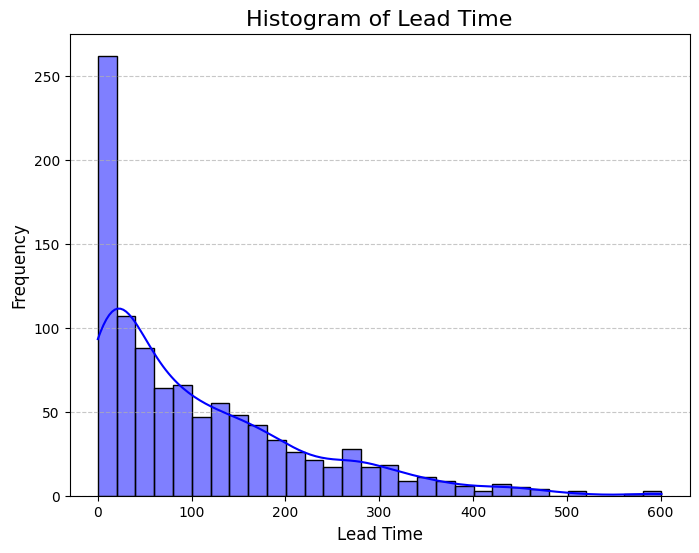

In [ ]:
plt.figure(figsize=(8, 6))
sns.histplot(df_with_missing['lead_time'], kde=True, bins=30, color='blue')
plt.title("Histogram of Lead Time", fontsize=16)
plt.xlabel("Lead Time", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


Try to find the best model for the distribution of X:

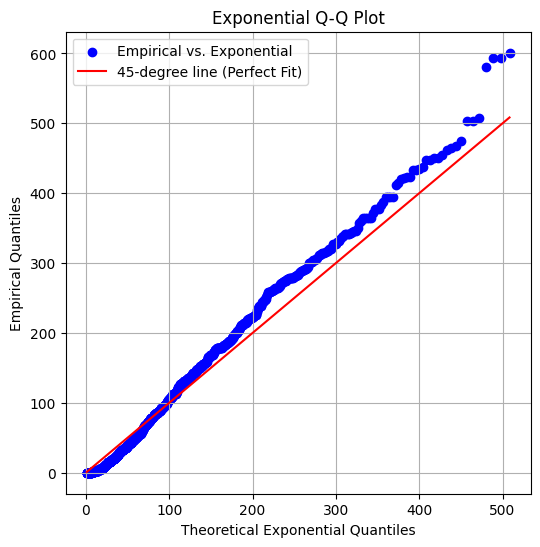

In [ ]:
lead_time_data = df_with_missing['lead_time'].values

lambda_hat = 1 / np.mean(lead_time_data)

exp_quantiles = stats.expon.ppf(np.linspace(0.01, 0.99, len(lead_time_data)), scale=1/lambda_hat)

empirical_quantiles = np.sort(lead_time_data)

plt.figure(figsize=(6,6))
plt.scatter(exp_quantiles, empirical_quantiles, label="Empirical vs. Exponential", color='blue')
plt.plot(exp_quantiles, exp_quantiles, 'r-', label="45-degree line (Perfect Fit)")

plt.xlabel("Theoretical Exponential Quantiles")
plt.ylabel("Empirical Quantiles")
plt.title("Exponential Q-Q Plot")
plt.legend()
plt.grid(True)

plt.show()


Based on the Exponential Q-Q plot generated, we can reasonably assume that
X (lead time) follows an exponential distribution, even though it is not a perfect fit.

#### SubSection B

In [ ]:
df_clean = df_with_missing.dropna(subset=['adr'])

X = df_clean['lead_time']
Y = df_clean['adr']

E_X = np.mean(X)

X_with_const = sm.add_constant(X)
model = sm.OLS(Y, X_with_const).fit()

beta_0_hat, beta_1_hat = model.params

mu_Y_hat = beta_0_hat + beta_1_hat * E_X

print(f"Estimated β₀: {beta_0_hat:.4f}")
print(f"Estimated β₁: {beta_1_hat:.4f}")
print(f"Mean of X (E[X]): {E_X:.4f}")
print(f"Estimated μ_Y: {mu_Y_hat:.4f}")


Estimated β₀: 75.0614
Estimated β₁: 0.0027
Mean of X (E[X]): 112.5795
Estimated μ_Y: 75.3690


Regression & Expectation:

Y=β_0+β_1X+ϵ ⇒  mu_y := E[Y]=β_0+β_1E[X]

When data is missing at random (MAR), the missingness mechanism depends only on observed data and not on the missing values themselves.

Under this assumption:

The observed data can provide unbiased estimates of the parameters of interest (e.g.,
β_0 and 𝛽_1).
We use the likelihood of the observed data to estimate
μ_Y, the expected value of 𝑌 which is computed from the observed data.

The equation

𝜇_𝑌=𝛽_0 + 𝛽_1 𝐸[𝑋]

holds because the relationship between
Y and
X is linear, and the MAR assumption ensures that 𝐸[𝑋] can be reliably estimated from the observed data.

#### SubSection C

In [ ]:
beta_2 = beta_dict["2"]
beta_4A = beta_dict["4A"]
beta_4B = beta_dict["4B"]

mu_Y_2 = beta_2[0] + beta_2[1] * E_X
mu_Y_4A = beta_4A[0] + beta_4A[1] * E_X
mu_Y_4B = beta_4B[0] + beta_4B[1] * E_X

# Print results
print(f"Estimated μ_Y using Model from Question 2: {mu_Y_2:.4f}")
print(f"Estimated μ_Y using Model from Question 4A (missing data removed): {mu_Y_4A:.4f}")
print(f"Estimated μ_Y using Model from Question 4B (missing data imputed with mean): {mu_Y_4B:.4f}")

# Compare how the missing data treatment affects the results
print("\nComparison:")
print(f"Difference between Model 2 and Model 4A: {abs(mu_Y_2 - mu_Y_4A):.4f}")
print(f"Difference between Model 2 and Model 4B: {abs(mu_Y_2 - mu_Y_4B):.4f}")
print(f"Difference between Model 4A and Model 4B: {abs(mu_Y_4A - mu_Y_4B):.4f}")


Estimated μ_Y using Model from Question 2: 100.4145
Estimated μ_Y using Model from Question 4A (missing data removed): 75.3690
Estimated μ_Y using Model from Question 4B (missing data imputed with mean): 75.3724

Comparison:
Difference between Model 2 and Model 4A: 25.0455
Difference between Model 2 and Model 4B: 25.0421
Difference between Model 4A and Model 4B: 0.0034


The large difference (~25) between the complete data model (Q2) and the missing data models (Q4A, Q4B) suggests that `adr` is **not missing completely at random (MCAR)**. The similarity between Q4A and Q4B implies that missingness is related to observed variables, supporting the **Missing at Random (MAR)** assumption. However, if unobserved factors influence missingness, **Missing Not at Random (MNAR)** is possible.